In [1]:
import pandas as pd
import numpy as np
import re
from wordcloud import WordCloud
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer

from transformers import BertForSequenceClassification, BertTokenizer
from transformers import BertModel, BertTokenizer
from transformers import BertForSequenceClassification, BertTokenizer, AdamW
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments

import torch
from torch.utils.data import DataLoader, TensorDataset, random_split

import warnings
warnings.filterwarnings('ignore')


from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

D:\anaconda\envs\new\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


# Loading the Dataset
---

In [2]:
import pandas as pd

# Load the dataset
df = pd.read_csv('AI.csv')

# Print the first few rows of the dataset
df.head()

,Unnamed: 0,text,generated
0,0,Participation in extracurricular Activities i...,1.0
1,1,Many students enter their high school career w...,1.0
2,2,"Dear Senator,\n\nI am Writing to you today to ...",1.0
3,3,The debate of whether animals should be treate...,1.0
4,4,Homeschooling and attending a traditional scho...,1.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  5000 non-null   int64  
 1   text        5000 non-null   object 
 2   generated   5000 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 117.3+ KB


In [4]:
df=df[['text','generated']]

In [5]:
df=df.reset_index(drop=True)

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')

In [7]:
# Preprocess the text
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]
    # Join the tokens back into a single string
    preprocessed_text = ' '.join(lemmatized_tokens)
    return preprocessed_text

df['text'] = df['text'].apply(preprocess_text)

In [8]:
sia=SentimentIntensityAnalyzer()

dict_sent=df["text"].apply(lambda z:sia.polarity_scores((z)))
print(dict_sent)
positive=[]
negative=[]
neutral=[]
sentiment=[]
compound=[]
for w in dict_sent:
    positive.append(w['pos'])
    negative.append(w['neg'])
    neutral.append(w['neu'])
    compound.append(w["compound"])
    if (w['compound']>0.05):
        sentiment.append("positive")
    elif (w['compound']<-0.05):
        sentiment.append("negative")
    else:
        sentiment.append("neutral")

0       {'neg': 0.038, 'neu': 0.57, 'pos': 0.392, 'com...
1       {'neg': 0.071, 'neu': 0.723, 'pos': 0.206, 'co...
2       {'neg': 0.033, 'neu': 0.689, 'pos': 0.279, 'co...
3       {'neg': 0.177, 'neu': 0.545, 'pos': 0.278, 'co...
4       {'neg': 0.044, 'neu': 0.72, 'pos': 0.237, 'com...
                              ...                        
4995    {'neg': 0.08, 'neu': 0.704, 'pos': 0.216, 'com...
4996    {'neg': 0.029, 'neu': 0.76, 'pos': 0.21, 'comp...
4997    {'neg': 0.071, 'neu': 0.75, 'pos': 0.179, 'com...
4998    {'neg': 0.109, 'neu': 0.586, 'pos': 0.305, 'co...
4999    {'neg': 0.119, 'neu': 0.56, 'pos': 0.321, 'com...
Name: text, Length: 5000, dtype: object


In [9]:
df['sentiment']=sentiment

In [10]:
# Word frequency analysis
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['text'])
word_freq = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
word_freq_sum = word_freq.sum().sort_values(ascending=False)
print(word_freq_sum.head(10))

student    15976
car        13064
people     12244
would      10058
school      8106
also        6803
help        6768
time        6582
like        6291
one         6258
dtype: int64


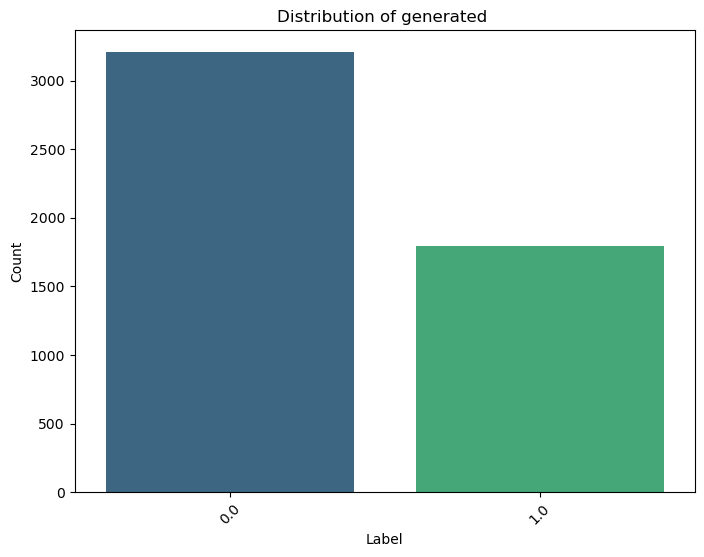

In [16]:

# Visualize the distribution of generated
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='generated', palette='viridis')
plt.title('Distribution of generated ')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

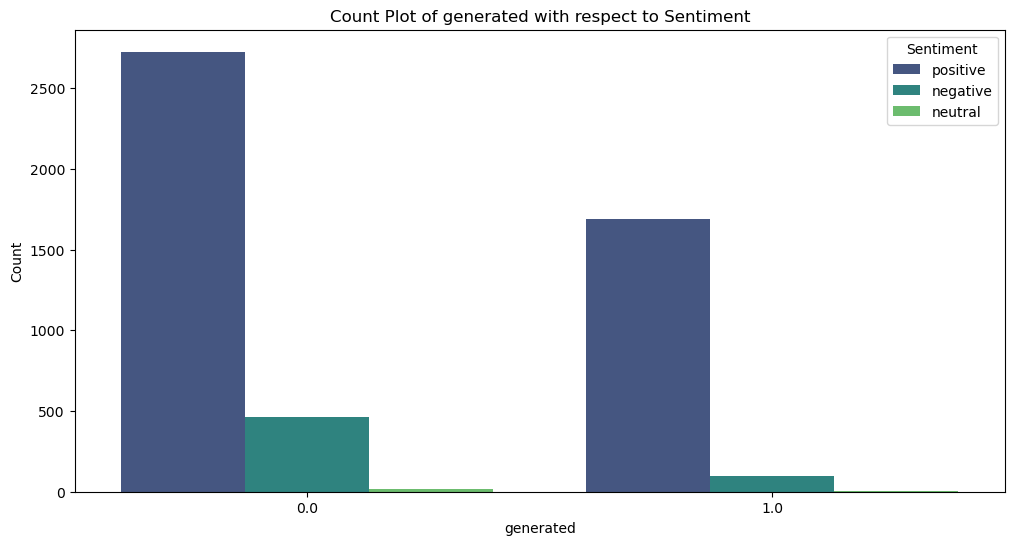

In [15]:
# count plot for generated with hue as Sentiment
plt.figure(figsize=(12, 6))
sns.countplot(x='generated', hue='sentiment', data=df, palette='viridis')
plt.title('Count Plot of generated with respect to Sentiment')
plt.xlabel('generated')
plt.ylabel('Count')
plt.legend(title='Sentiment')

plt.show()

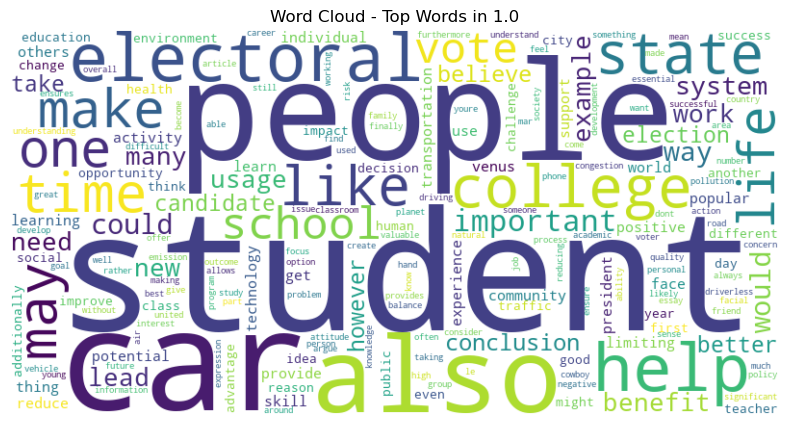

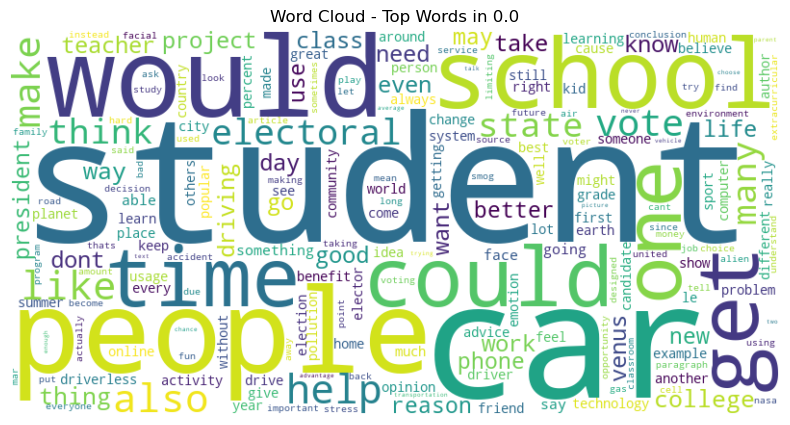

In [17]:
# Word frequency analysis and word clouds for each class
classes = df['generated'].unique()

for label in classes:
    # Filter the data for the current class
    class_data = df[df['generated'] == label]

    # Word frequency analysis
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(class_data['text'])

    word_freq = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
    word_freq_sum = word_freq.sum().sort_values(ascending=False)

    # Visualize word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_sum)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud - Top Words in {label}')
    plt.axis('off')
    plt.show()

#  Parameters and Data Preparation

In [15]:
# Parameters
model_name = 'distilbert-base-uncased'
batch_size = 16
epochs = 3
learning_rate = 2e-5

# Tokenize the text and Prepare DataLoaders

In [17]:
# Tokenize the text
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)
encodings = tokenizer(df['text'].tolist(), truncation=True, padding=True, max_length=512)


# Convert to torch tensors
input_ids = torch.tensor(encodings['input_ids'])
attention_masks = torch.tensor(encodings['attention_mask'])

labels = torch.tensor(df['generated'].values, dtype=torch.long)

# Create the dataset
dataset = TensorDataset(input_ids, attention_masks, labels)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create the DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

# Fine tuning Learning Rate  and Model Training
- Define a set of learning rates to try out
- Initialize best_accuracy = 0, best_learning_rate = None, device
- Iterate over learning rates:
  - Load the pre-trained BERT model
  - Set up the optimizer with the current learning rate
  - Set up the learning rate scheduler
  - Training loop over epochs
  - Evaluation loop
  - Calculate the accuracy of the model
  - Save the best model based on validation accuracy



In [19]:
# Define a set of learning rates to try out
learning_rates = [5e-5, 3e-5, 2e-5, 1e-5, 5e-6]

best_accuracy = 0
best_learning_rate = None

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Iterate over learning rates
for lr in learning_rates:
    print(f"Training with learning rate: {lr}")

    # Load the pre-trained BERT model
    model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=len(np.unique(labels)))
    model.to(device)

    # Set up the optimizer with the current learning rate
    optimizer = AdamW(model.parameters(), lr=lr)

    # Set up the learning rate scheduler
    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    # Training loop
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in train_dataloader:
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch

            model.zero_grad()

            outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)

            loss = outputs.loss
            total_loss += loss.item()

            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()

            scheduler.step()

        avg_train_loss = total_loss / len(train_dataloader)
        print(f"Epoch {epoch + 1}/{epochs} | Average train loss: {avg_train_loss}")

    # Evaluation loop
    model.eval()
    predictions, true_labels = [], []

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids, attention_mask=b_input_mask)

        logits = outputs.logits
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        predictions.append(logits)
        true_labels.append(label_ids)

    # Calculate the accuracy of the model
    predictions = np.concatenate(predictions, axis=0)
    true_labels = np.concatenate(true_labels, axis=0)
    predicted_labels = np.argmax(predictions, axis=1)
    accuracy = accuracy_score(true_labels, predicted_labels)
    print(f"Validation Accuracy for learning rate {lr}: {accuracy}")

    # Save the best model
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_learning_rate = lr
        model.save_pretrained(f'./my_fine_tuned_model_lr_{lr}')
        tokenizer.save_pretrained(f'./my_fine_tuned_model_lr_{lr}')

Training with learning rate: 5e-05


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3 | Average train loss: 0.22658582185208798
Epoch 2/3 | Average train loss: 0.05911767682526261
Epoch 3/3 | Average train loss: 0.030369501147419216
Validation Accuracy for learning rate 5e-05: 0.982
Training with learning rate: 3e-05


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3 | Average train loss: 0.25562019255943597
Epoch 2/3 | Average train loss: 0.07302240984421224
Epoch 3/3 | Average train loss: 0.030003095089457928
Validation Accuracy for learning rate 3e-05: 0.974
Training with learning rate: 2e-05


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3 | Average train loss: 0.24139648849517106
Epoch 2/3 | Average train loss: 0.08510315709840506
Epoch 3/3 | Average train loss: 0.04044245433434844
Validation Accuracy for learning rate 2e-05: 0.973
Training with learning rate: 1e-05


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3 | Average train loss: 0.2977465459406376
Epoch 2/3 | Average train loss: 0.12053108654357493
Epoch 3/3 | Average train loss: 0.07576171074062586
Validation Accuracy for learning rate 1e-05: 0.973
Training with learning rate: 5e-06


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3 | Average train loss: 0.3740416677594185
Epoch 2/3 | Average train loss: 0.1398475743085146
Epoch 3/3 | Average train loss: 0.10180555136874318
Validation Accuracy for learning rate 5e-06: 0.963


In [23]:
print(f"Best Learning Rate: {best_learning_rate}")
print(f"Best Validation Accuracy: {best_accuracy}")


Best Learning Rate: 5e-05
Best Validation Accuracy: 0.982


# Load Best Model and Evaluate
- Load the best model for further use or analysis
- Move the model to the GPU if available
- Evaluation loop for the best model
- Concatenate the results
- Print the classification report
- Plot the confusion matrix
- Indicate that training and evaluation are complete

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       675
           1       0.98      0.97      0.97       325

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000



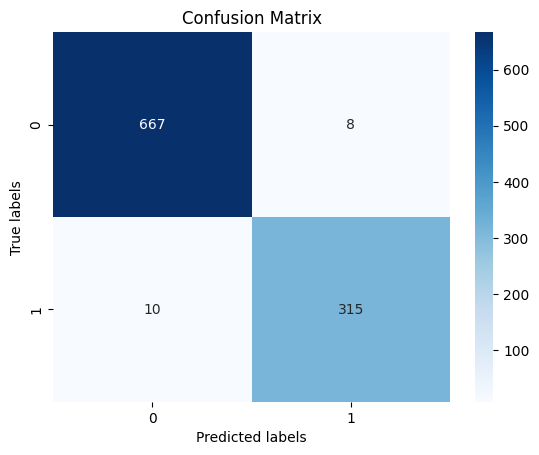

Training and evaluation complete


In [28]:


# Load the best model for further use or analysis
best_model_path = f'./my_fine_tuned_model_lr_{best_learning_rate}'
model = DistilBertForSequenceClassification.from_pretrained(best_model_path)
tokenizer = DistilBertTokenizerFast.from_pretrained(best_model_path)

# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Evaluation loop for the best model
model.eval()
predictions, true_labels = [], []

for batch in validation_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        outputs = model(b_input_ids, attention_mask=b_input_mask)

    logits = outputs.logits
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    predictions.append(logits)
    true_labels.append(label_ids)

# Concatenate the results
predictions = np.concatenate(predictions, axis=0)
true_labels = np.concatenate(true_labels, axis=0)
predicted_labels = np.argmax(predictions, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels))

# Confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax, cmap='Blues', fmt='g')

# Labels, title, and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.show()

print("Training and evaluation complete")